In [ ]:
import os
from IPython.display import Audio

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Audio

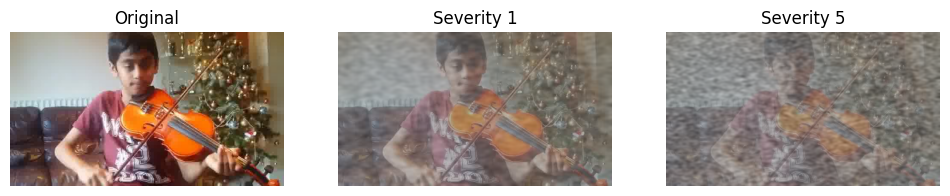

In [22]:
def gaussian_noise(x, severity=1):
    from scipy.ndimage import gaussian_filter
    """Applies Gaussian noise simulating smoke-like effect on an image."""
    
    # Smoke parameters based on severity
    c = [(1.5, 2), (2, 2), (2.5, 1.7), (2.5, 1.5), (3, 1.4)][severity - 1]

    # Normalize the image
    x = np.array(x) / 255.0
    max_val = x.max()

    # Generate smoke-like noise (Gaussian blobs)
    h, w, _ = x.shape  # Get image dimensions
    noise = np.random.rand(224, 224)  # Initial noise at fixed size
    smoke_pattern = gaussian_filter(noise, sigma=c[1])  # Apply Gaussian blur

    # Resize smoke pattern to match the input image size
    smoke_pattern = cv2.resize(smoke_pattern, (w, h), interpolation=cv2.INTER_LINEAR)

    # Add color tint for smoke (grayish appearance)
    smoke_pattern = np.expand_dims(smoke_pattern, axis=-1)  # Add channel dimension
    smoke_pattern = np.repeat(smoke_pattern, 3, axis=-1)    # Match RGB channels

    # Blend smoke with the image
    x += c[0] * smoke_pattern

    # Normalize and clip
    return np.clip(x * max_val / (max_val + c[0]), 0, 1) * 255  # Convert back to [0, 255]

# Load the image
image_path = "/mnt/user/saksham/AV_robust/AV-C-Robustness-Benchmark/data_recipe/analysis_helper/data/clean/playing_violin__fiddle.jpg"  # Change this to your image path
original = cv2.imread(image_path)  # Load using OpenCV
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Apply Gaussian noise at severity 1 and 5
image_severity_1 = gaussian_noise(original, severity=1).astype(np.uint8)
image_severity_5 = gaussian_noise(original, severity=5).astype(np.uint8)

# Display the images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original)
axes[0].set_title("Original")
axes[1].imshow(image_severity_1)
axes[1].set_title("Severity 1")
axes[2].imshow(image_severity_5)
axes[2].set_title("Severity 5")

for ax in axes:
    ax.axis("off")

plt.show()

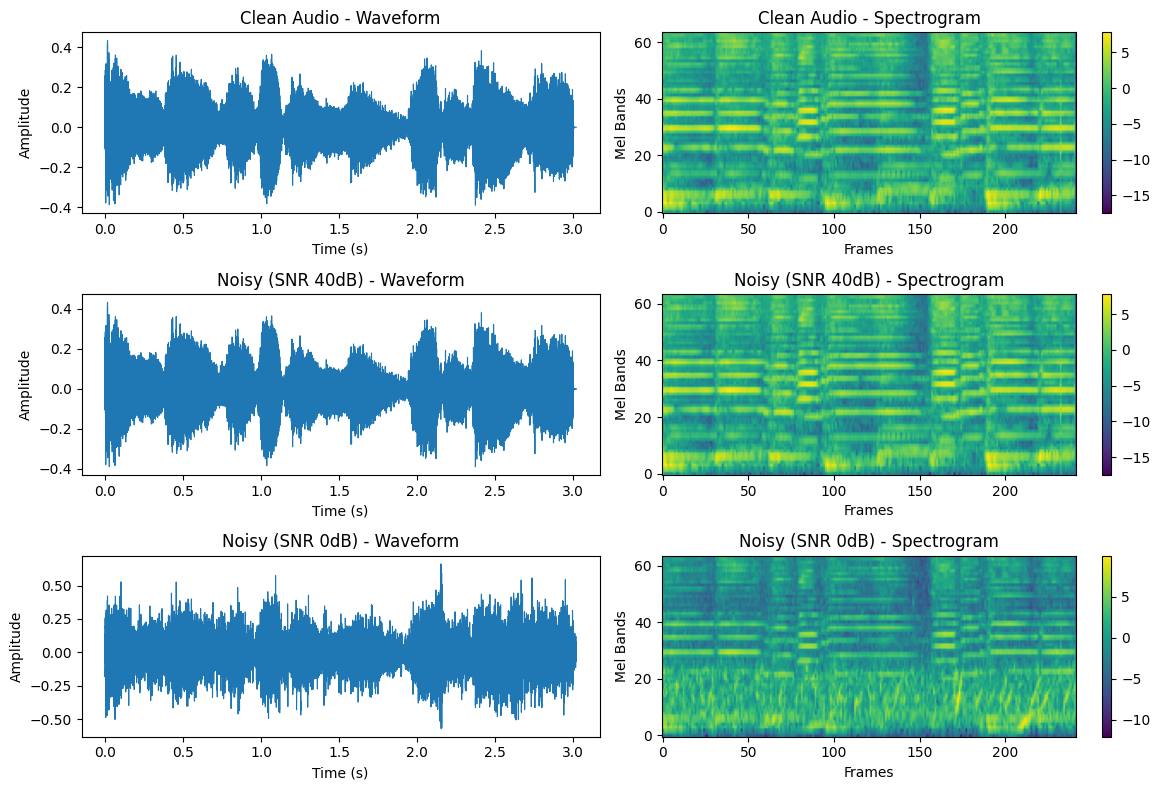

In [17]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

NOISE_SNRS = [40, 30, 20, 10, 0]  # SNR levels for different noise intensities

def add_gaussian_noise(audio_file, intensity):    
    def add_env_noise(audio_file, output_path, intensity, noise_dir=''):
        waveform, sr = torchaudio.load(audio_file)
        assert sr == 16000, "Noise file must have a sample rate of 16 kHz."
        xlen = waveform.shape[-1]
        noise_files = os.listdir(noise_dir)
        if not noise_files:
            raise FileNotFoundError("No noise files found in the directory.")
        noise_file = np.random.choice(noise_files)
        noise_file = os.path.join(noise_dir, noise_file)
        noise_raw, sr = torchaudio.load(noise_file)
        if sr != 16000:
            noise_raw = torchaudio.transforms.Resample(sr, 16000)(noise_raw)
        noise = noise_raw[..., :xlen]
        while noise.shape[-1] < xlen:
            noise = torch.cat([noise, noise], -1)
        noise = noise[..., :xlen] 
        snr_tensor = torch.full_like(waveform[:, 0], NOISE_SNRS[intensity-1])
        waveform_noise = F.add_noise(waveform, noise, snr_tensor)
        return waveform_noise

    spatter_dir = '/mnt/user/saksham/AV_robust/AV-C-Robustness-Benchmark/data_recipe/src/noise_files/underwater'
    output_path = ''
    return add_env_noise(audio_file, output_path, intensity, noise_dir=spatter_dir)
    # return waveform_reverbed
    

def plot_waveform_and_spectrogram(waveform, sr, title, ax1, ax2):
    """
    Plots the waveform and spectrogram of an audio signal.
    """
    ax1.plot(torch.arange(waveform.shape[1]) / sr, waveform.numpy().squeeze(), linewidth=0.8)
    ax1.set_title(f"{title} - Waveform")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")

    transform = T.MelSpectrogram(sample_rate=sr, n_mels=64)
    mel_spec = transform(waveform)

    im = ax2.imshow(mel_spec.log2().numpy().squeeze(), aspect='auto', origin='lower')
    ax2.set_title(f"{title} - Spectrogram")
    ax2.set_xlabel("Frames")
    ax2.set_ylabel("Mel Bands")
    plt.colorbar(im, ax=ax2)

# Load audio file
audio_path = "/mnt/user/saksham/AV_robust/AV-C-Robustness-Benchmark/data_recipe/analysis_helper/data/clean/playing_violin__fiddle.wav"  # Change this to your actual audio file path
waveform, sr = torchaudio.load(audio_path)

# Generate noisy versions
waveform_noise_1 = add_gaussian_noise(audio_path, 1)  # Least noise (SNR = 40dB)
waveform_noise_5 = add_gaussian_noise(audio_path, 5)  # Most noise (SNR = 0dB)

# Plot waveforms and spectrograms
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

plot_waveform_and_spectrogram(waveform, sr, "Clean Audio", axes[0, 0], axes[0, 1])
plot_waveform_and_spectrogram(waveform_noise_1, sr, "Noisy (SNR 40dB)", axes[1, 0], axes[1, 1])
plot_waveform_and_spectrogram(waveform_noise_5, sr, "Noisy (SNR 0dB)", axes[2, 0], axes[2, 1])

plt.tight_layout()
plt.show()


In [18]:
Audio(waveform_noise_5, rate=sr)